# Portfolio Simulation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
StockPrices = pd.DataFrame()
market_value_list=[]

ticker_list = ['BILI', 'JD', 'BEST', 'TOUR']

for ticker in ticker_list:
    stock_data = pd.read_csv(ticker + ".csv", encoding='utf-8',index_col = 0)
    StockPrices[ticker] = stock_data['Adj Close']  #Get the Adj closing price of each stock
StockPrices.index.name = 'date'  
# The first 5 lines of output data
print(StockPrices.head())

                 BILI         JD  BEST  TOUR
date                                        
2020-01-02  20.950001  37.730000  5.88  2.39
2020-01-03  22.080000  37.990002  5.88  2.46
2020-01-06  23.209999  38.000000  5.90  2.51
2020-01-07  23.129999  38.320000  5.98  2.60
2020-01-08  23.840000  38.299999  6.43  2.52


In [4]:
# Calculate daily rate of return and drop missing values
StockReturns = StockPrices.pct_change().dropna()
print(StockReturns.head())

                BILI        JD      BEST      TOUR
date                                              
2020-01-03  0.053938  0.006891  0.000000  0.029289
2020-01-06  0.051177  0.000263  0.003401  0.020325
2020-01-07 -0.003447  0.008421  0.013559  0.035857
2020-01-08  0.030696 -0.000522  0.075251 -0.030769
2020-01-09 -0.028523  0.015666 -0.026439  0.015873


          BILI        JD      BEST      TOUR
BILI  1.000000  0.601693  0.344231  0.483881
JD    0.601693  1.000000  0.365789  0.584386
BEST  0.344231  0.365789  1.000000  0.357872
TOUR  0.483881  0.584386  0.357872  1.000000


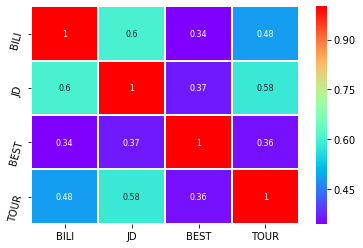

In [5]:
# Calculate the correlation matrix
correlation_matrix = StockReturns.corr()
print(correlation_matrix)

#Plotting a matrix heat map
import seaborn as sns

sns.heatmap(correlation_matrix,annot=True,cmap='rainbow',linewidths=1.0,annot_kws={'size':8})
plt.xticks(rotation=0)
plt.yticks(rotation=75)
plt.show()

          BILI        JD      BEST      TOUR
BILI  0.527032  0.256788  0.155433  0.246894
JD    0.256788  0.345590  0.133748  0.241454
BEST  0.155433  0.133748  0.386858  0.156444
TOUR  0.246894  0.241454  0.156444  0.493979


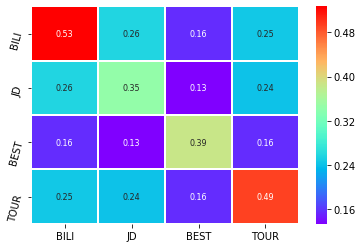

In [6]:
# Calculate the covariance matrix
cov_mat = StockReturns.cov()
# Annualized covariance matrix
cov_mat_annual = cov_mat * 252
# Output covariance matrix
print(cov_mat_annual)

sns.heatmap(cov_mat_annual,annot=True,cmap='rainbow',linewidths=1.0,annot_kws={'size':8})
plt.xticks(rotation=0)
plt.yticks(rotation=75)
plt.show()

## Markowitz model

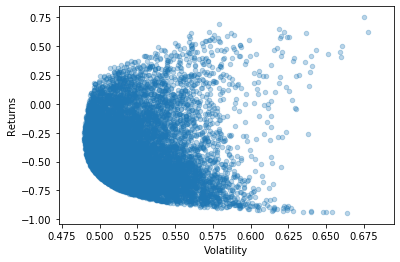

In [6]:
# Set the number of simulations
number = 10000
# Set an empty numpy array, used to store the weight, yield and standard deviation obtained from each simulation
random_p = np.empty((number, 6))
# Set random number seed
np.random.seed(6)
 
for i in range(number):
    #Generate 4 random numbers to get a set of random weight data
    random4=np.random.random(4)
    random_weight=random4/np.sum(random4)
 
    #Calculate the annual average rate of return
    mean_return=StockReturns.mul(random_weight,axis=1).sum(axis=1).mean()
    annual_return=(1+mean_return)**252-1
 
    #Calculate the annualized standard deviation, which also becomes the volatility
    random_volatility=np.sqrt(np.dot(random_weight.T,np.dot(cov_mat_annual,random_weight)))
 
    random_p[i][:4]=random_weight
    random_p[i][4]=annual_return
    random_p[i][5]=random_volatility

RandomPortfolios=pd.DataFrame(random_p)
RandomPortfolios.columns=[ticker +'_weight' for ticker in ticker_list]+['Returns','Volatility']
 
#Draw a scatterplot
RandomPortfolios.plot('Volatility','Returns',kind='scatter',alpha=0.3)
plt.show()


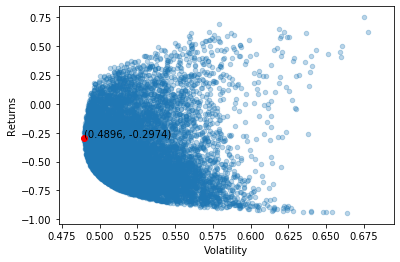

In [7]:
# Find the index value of the data with the smallest standard deviation
min_index = RandomPortfolios.Volatility.idxmin()
 
# Highlight the point of least risk in the return-risk scatterplot
RandomPortfolios.plot('Volatility', 'Returns', kind='scatter', alpha=0.3)
x = RandomPortfolios.loc[min_index,'Volatility']
y = RandomPortfolios.loc[min_index,'Returns']
plt.scatter(x, y, color='red')
#Display the coordinates of the point in the graph and keep four decimal places
plt.text(np.round(x,4),np.round(y,4),(np.round(x,4),np.round(y,4)),ha='left',va='bottom',fontsize=10)
plt.show()

In [8]:
numstocks = 4

stock_return = StockReturns.copy()
# Extract the weight corresponding to the minimum fluctuation combination
GMV_weights = np.array(RandomPortfolios.iloc[min_index, 0:numstocks])
# Calculate GMV portfolio income
StockReturns['Portfolio_GMV'] = stock_return.mul(GMV_weights, axis=1).sum(axis=1)
print(GMV_weights)

[0.09346615 0.3790012  0.39873361 0.12879904]


## Sharpe model

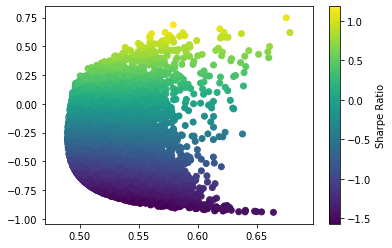

In [9]:
# Set the risk-free rate of return to 0
risk_free = 0
# Calculate the Sharpe ratio of each asset
RandomPortfolios['Sharpe'] = (RandomPortfolios.Returns - risk_free) / RandomPortfolios.Volatility
# Draw a scatterplot of the return-standard deviation, and use color to depict the Sharpe ratio
plt.scatter(RandomPortfolios.Volatility, RandomPortfolios.Returns, c=RandomPortfolios.Sharpe)
plt.colorbar(label='Sharpe Ratio')
plt.show()

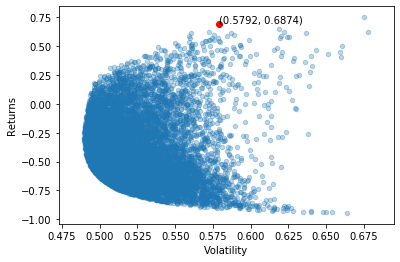

In [10]:
# Find the index value corresponding to the largest Sharp ratio data
max_index = RandomPortfolios.Sharpe.idxmax()
# Highlight the point with the largest Sharpe ratio in the return-risk scatterplot
RandomPortfolios.plot('Volatility', 'Returns', kind='scatter', alpha=0.3)
x = RandomPortfolios.loc[max_index,'Volatility']
y = RandomPortfolios.loc[max_index,'Returns']
plt.scatter(x, y, color='red')
#Display the coordinates of the point in the graph and keep four decimal places
plt.text(np.round(x,4),np.round(y,4),(np.round(x,4),np.round(y,4)),ha='left',va='bottom',fontsize=10)
plt.show()

In [12]:
# Extract the weight corresponding to the maximum Sharpe ratio combination
MSR_weights = np.array(RandomPortfolios.iloc[max_index, 0:numstocks])
# Calculate the revenue of the MSR portfolio
StockReturns['Portfolio_MSR'] = stock_return.mul(MSR_weights, axis=1).sum(axis=1)
print(MSR_weights)

[4.33613401e-01 5.62434171e-01 3.26084665e-04 3.62634340e-03]
